## Imports and Libraries

In [1]:
!pip install -q torchsummary
!pip install -q torchmetrics[detection]

In [2]:
import os
import re
import zipfile
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
from time import time
from tqdm import tqdm
from pycocotools.coco import COCO
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from skimage.io import imread
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

import torch
import cv2
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision
from skimage.transform import resize
from torchvision.transforms import v2 as T
from torchsummary import summary
from torchvision.utils import save_image

from matplotlib import pyplot as plt
from torchvision.io import read_image, ImageReadMode

from torchvision.models import resnet50, ResNet50_Weights, densenet121, DenseNet121_Weights
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from torchmetrics.detection import MeanAveragePrecision, IntersectionOverUnion
from torchmetrics.functional.detection import intersection_over_union
from torchvision.utils import draw_bounding_boxes

from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.models.detection import _utils
from torchvision.models.detection import SSD300_VGG16_Weights
from torchvision.ops import box_iou, complete_box_iou, complete_box_iou_loss

%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)
plt.ion()


In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
dataDir = '/kaggle/input/brain-mri-dataset-containing-8-classes/image_224x224_no_augmentation/kaggle/working/processed/'
detDir = '/kaggle/input/detect-tumours/detect/'
outDir = '/kaggle/working/result/'
anns = '/kaggle/input/detect-tumours/detect/annotations/instances_default.json'
folders = ['glioma', 'notumor', 'meningioma', 'pituitary']
CLASSES = {'notumor': 0, 
           'glioma': 1, 
           'meningioma': 2,
           'pituitary':3    
}

# Part I: Classification

In [5]:
BATCH_SIZE = 64
IMG_SIZE = 224
IMG_SIZE_D = 320
generator = torch.Generator().manual_seed(1001)

## Transformations

In [6]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomInvert()
    ])

## Datasets and Dataloaders

In [7]:
class Brain(torch.utils.data.Dataset):
    def __init__(self, root, label, transform):
        self.root = root
        self.label = label
        self.transforms = transform
        self.imgs = os.listdir(os.path.join(self.root, self.label))

    def __getitem__(self, idx):
        # load images and labels
        img_path = os.path.join(self.root, self.label, self.imgs[idx])
        img = Image.open(img_path)
        target = CLASSES[self.label]

        return self.transforms(img), torch.tensor(target), self.label

    def __len__(self):
        return len(self.imgs)

In [8]:
data_1 = Brain(dataDir, folders[0], transformer)
data_2 = Brain(dataDir, folders[1], transformer)
data_3 = Brain(dataDir, folders[2], transformer)
data_4 = Brain(dataDir, folders[3], transformer)
print(f'classes size: \n {folders[0]} -- {len(data_1)} \n {folders[1]} -- {len(data_2)} \n {folders[2]} -- {len(data_3)} \n {folders[3]} -- {len(data_4)} \n')
data_brain = ConcatDataset([data_1, data_2, data_3, data_4])
train, valid, test = torch.utils.data.random_split(data_brain, [.6, .2, .2], generator=generator)
print(f"train - {len(train)} \n valid - {len(valid)} \n test - {len(test)}")

classes size: 
 glioma -- 3573 
 notumor -- 1990 
 meningioma -- 2869 
 pituitary -- 3214 

train - 6988 
 valid - 2329 
 test - 2329


In [9]:
train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

## First Look

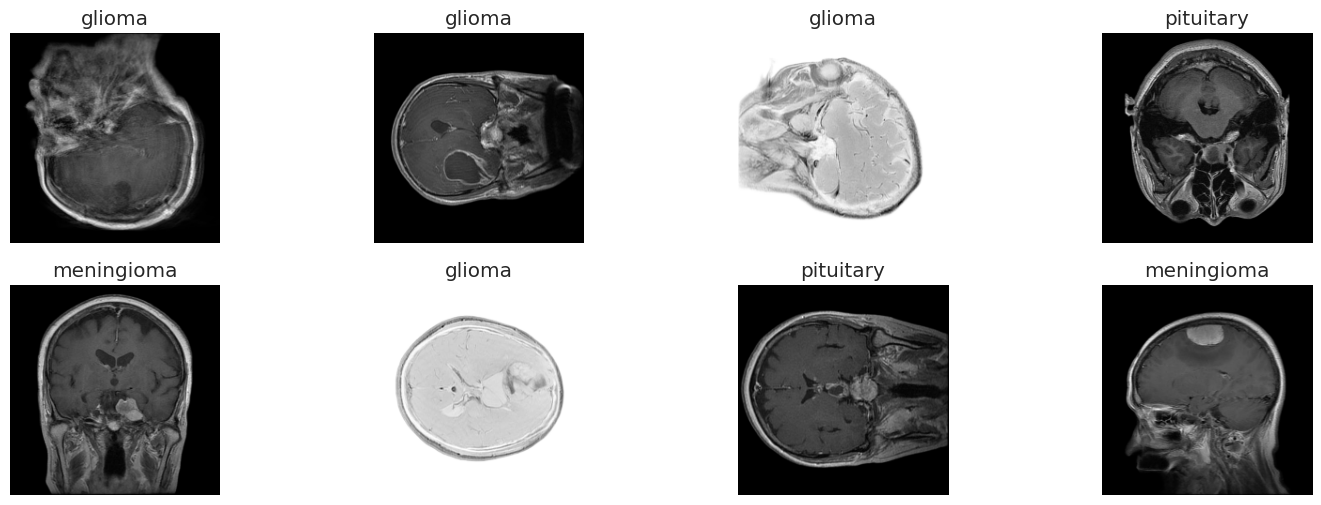

In [10]:
look = next(iter(train_dataloader))
plt.figure(figsize=(18, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.axis("off")
    plt.imshow(look[0][i].permute(1,2,0))
    plt.title(look[2
                  ][i])
plt.show();

## Train, Eval and Vizualize functions

In [11]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels, _ in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [12]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels, _ in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [13]:
def predict(model, test_loader):
    running_corrects = 0
    processed_size = 0
    with torch.no_grad():
        logits = []
        preds = []
        answers = []

        for inputs, labels, _ in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.eval()
            outputs = model(inputs)
            logits.append(outputs.cpu())
            preds.append(torch.argmax(outputs, 1).cpu())
            answers.append(labels.cpu())
            running_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)
            processed_size += inputs.size(0)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    preds = torch.cat(preds, dim=-1).numpy()
    answers = torch.cat(answers, dim=-1).numpy()
    test_acc = running_corrects.cpu().numpy() / processed_size
    return answers, preds, probs, test_acc

In [14]:
def train(train, val, model, epochs, rate, criterion):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=rate)
        sch = lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train, criterion, opt, sch)

            val_loss, val_acc = eval_epoch(model, val, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [15]:
def vizualize(h, model):
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(model)
    plt.show()
    plt.plot(acc, label="train_accuracy")
    plt.plot(val_acc, label="validation_accuracy")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title(model)
    plt.show()

## Pretrained models

### ResNet50 (freeze layers)

In [16]:
weights = ResNet50_Weights.DEFAULT
resnet = resnet50(weights=weights)

# Set requires_grad = False for all parameters
for param in resnet.parameters():
    param.requires_grad = False

# Re-enable requires_grad for the last 3 layers
layers = list(resnet.children())
for layer in layers[-4:]:
    for param in layer.parameters():
        param.requires_grad = True
in_features = 2048
out_features = 4
resnet.fc = nn.Linear(in_features, out_features)
resnet = resnet.to(device)
# summary(resnet, (3,IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 216MB/s]


### Mobilenet V2

In [17]:
mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=False),
                  nn.Linear(in_features=mobilenet.classifier[1].in_features, out_features=4, bias=True))
mobilenet = mobilenet.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 121MB/s] 


### DenseNet 121

In [18]:
weights = DenseNet121_Weights.DEFAULT
dnet = densenet121(weights=weights)

in_features = 1024
out_features = 4
dnet.classifier = nn.Linear(in_features, out_features)
dnet = dnet.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 176MB/s] 


## Training

In [19]:
ce = nn.CrossEntropyLoss()
lr = 3e-4

In [20]:
history = train(train_dataloader, valid_dataloader, model=resnet, epochs=10, rate=lr, criterion=ce)

epoch:  10%|█         | 1/10 [01:47<16:04, 107.16s/it]


Epoch 001 train_loss: 0.3333     val_loss 0.1692 train_acc 0.8758 val_acc 0.9420


epoch:  20%|██        | 2/10 [03:01<11:43, 87.94s/it]


Epoch 002 train_loss: 0.1211     val_loss 0.1134 train_acc 0.9566 val_acc 0.9626


epoch:  30%|███       | 3/10 [04:16<09:33, 81.89s/it]


Epoch 003 train_loss: 0.0793     val_loss 0.2019 train_acc 0.9721 val_acc 0.9386


epoch:  40%|████      | 4/10 [05:30<07:54, 79.01s/it]


Epoch 004 train_loss: 0.0605     val_loss 0.1200 train_acc 0.9794 val_acc 0.9588


epoch:  50%|█████     | 5/10 [06:45<06:27, 77.44s/it]


Epoch 005 train_loss: 0.0566     val_loss 0.0625 train_acc 0.9820 val_acc 0.9790


epoch:  60%|██████    | 6/10 [08:00<05:05, 76.49s/it]


Epoch 006 train_loss: 0.0251     val_loss 0.0493 train_acc 0.9933 val_acc 0.9845


epoch:  70%|███████   | 7/10 [09:16<03:48, 76.28s/it]


Epoch 007 train_loss: 0.0150     val_loss 0.0447 train_acc 0.9961 val_acc 0.9858


epoch:  80%|████████  | 8/10 [10:31<02:32, 76.02s/it]


Epoch 008 train_loss: 0.0121     val_loss 0.0424 train_acc 0.9969 val_acc 0.9845


epoch:  90%|█████████ | 9/10 [11:46<01:15, 75.57s/it]


Epoch 009 train_loss: 0.0096     val_loss 0.0361 train_acc 0.9967 val_acc 0.9867


epoch: 100%|██████████| 10/10 [13:01<00:00, 78.10s/it]


Epoch 010 train_loss: 0.0080     val_loss 0.0378 train_acc 0.9977 val_acc 0.9858


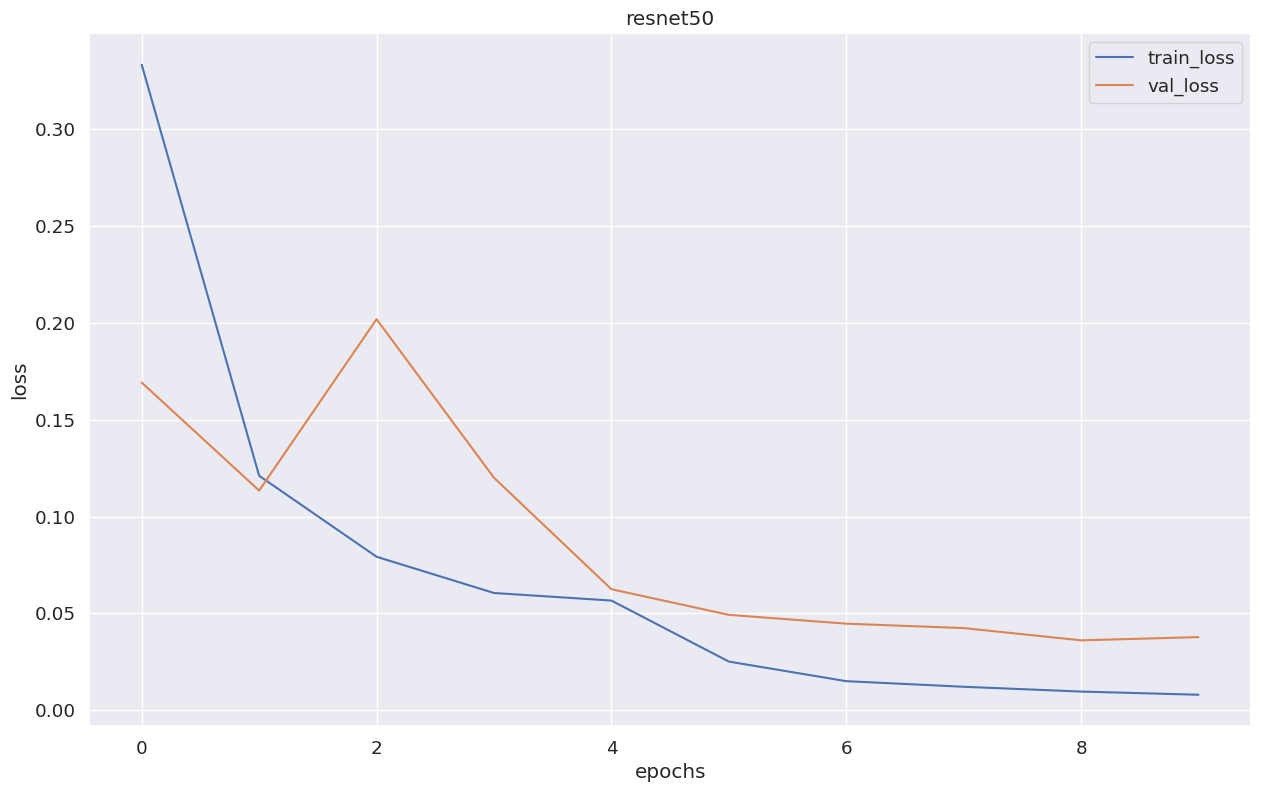

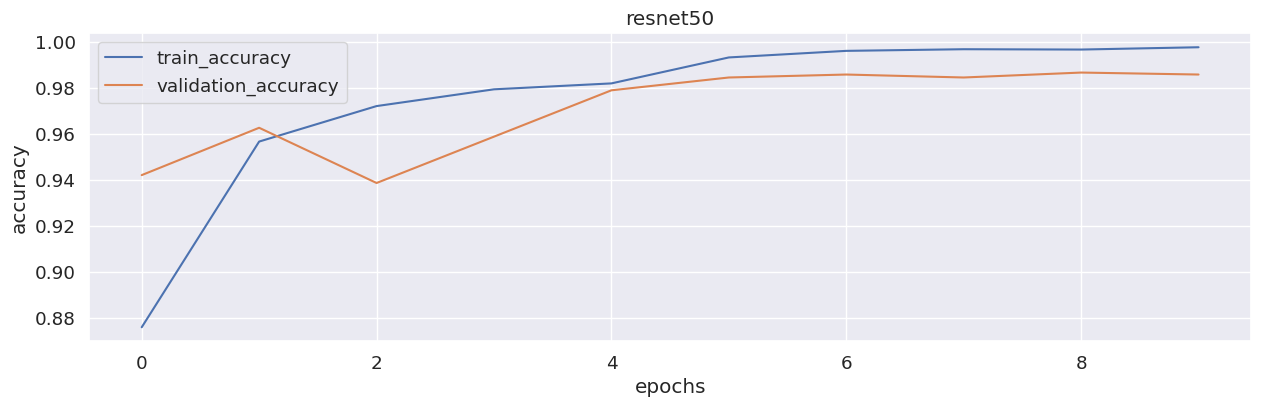

In [21]:
vizualize(history, 'resnet50')

In [22]:
history_1 = train(train_dataloader, valid_dataloader, model=mobilenet, epochs=10, rate=lr, criterion=ce)

epoch:  10%|█         | 1/10 [00:54<08:14, 54.97s/it]


Epoch 001 train_loss: 0.3289     val_loss 0.1886 train_acc 0.8759 val_acc 0.9283


epoch:  20%|██        | 2/10 [01:49<07:17, 54.69s/it]


Epoch 002 train_loss: 0.1637     val_loss 0.1217 train_acc 0.9419 val_acc 0.9592


epoch:  30%|███       | 3/10 [02:44<06:22, 54.65s/it]


Epoch 003 train_loss: 0.1069     val_loss 0.1020 train_acc 0.9624 val_acc 0.9652


epoch:  40%|████      | 4/10 [03:39<05:28, 54.80s/it]


Epoch 004 train_loss: 0.0802     val_loss 0.0892 train_acc 0.9717 val_acc 0.9682


epoch:  50%|█████     | 5/10 [04:33<04:33, 54.77s/it]


Epoch 005 train_loss: 0.0612     val_loss 0.0839 train_acc 0.9804 val_acc 0.9699


epoch:  60%|██████    | 6/10 [05:28<03:39, 54.90s/it]


Epoch 006 train_loss: 0.0353     val_loss 0.0469 train_acc 0.9897 val_acc 0.9854


epoch:  70%|███████   | 7/10 [06:23<02:43, 54.66s/it]


Epoch 007 train_loss: 0.0261     val_loss 0.0456 train_acc 0.9926 val_acc 0.9858


epoch:  80%|████████  | 8/10 [07:17<01:49, 54.69s/it]


Epoch 008 train_loss: 0.0207     val_loss 0.0384 train_acc 0.9951 val_acc 0.9863


epoch:  90%|█████████ | 9/10 [08:13<00:54, 54.87s/it]


Epoch 009 train_loss: 0.0175     val_loss 0.0362 train_acc 0.9954 val_acc 0.9884


epoch: 100%|██████████| 10/10 [09:09<00:00, 54.90s/it]


Epoch 010 train_loss: 0.0140     val_loss 0.0502 train_acc 0.9960 val_acc 0.9811


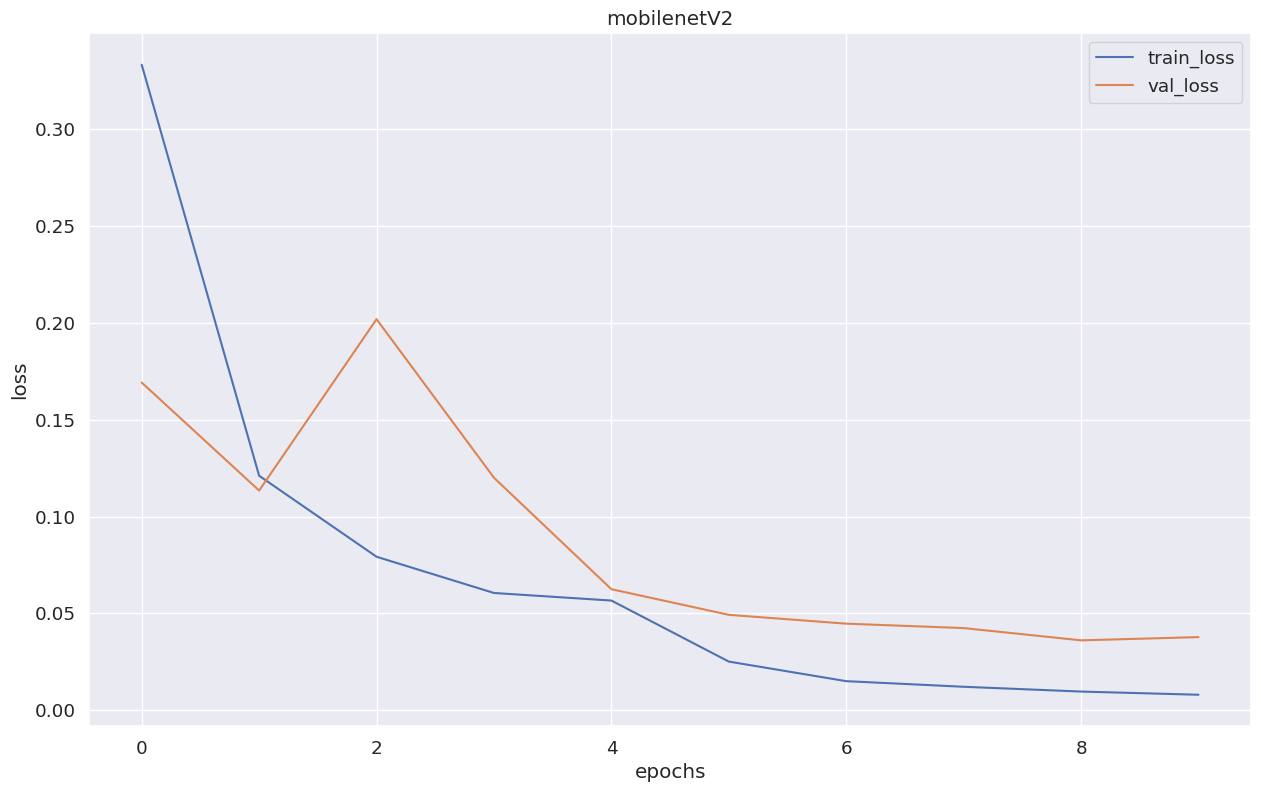

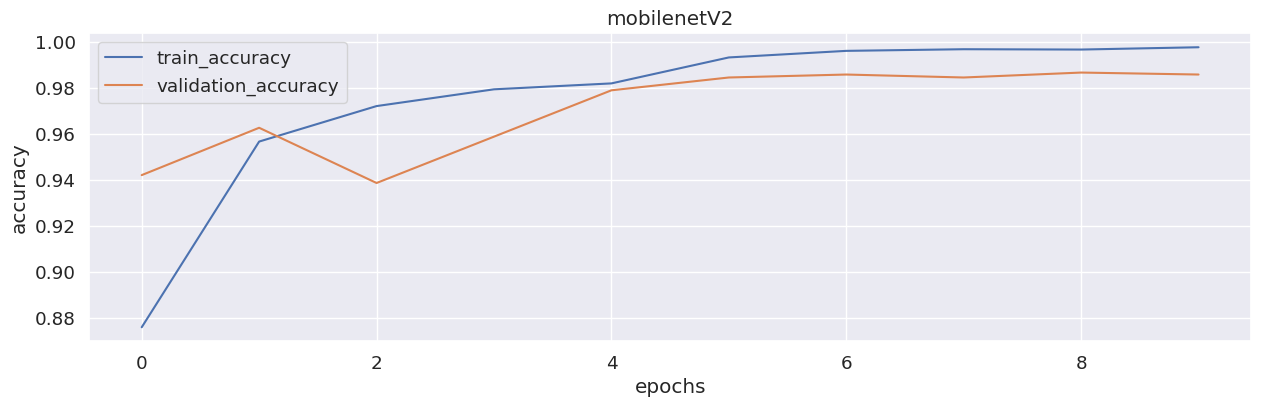

In [23]:
vizualize(history_1, 'mobilenetV2')

In [24]:
history_2 = train(train_dataloader, valid_dataloader, model=dnet, epochs=10, rate=lr, criterion=ce)

epoch:  10%|█         | 1/10 [01:42<15:24, 102.72s/it]


Epoch 001 train_loss: 0.3013     val_loss 0.2195 train_acc 0.8845 val_acc 0.9193


epoch:  20%|██        | 2/10 [03:25<13:40, 102.54s/it]


Epoch 002 train_loss: 0.1258     val_loss 0.1474 train_acc 0.9551 val_acc 0.9416


epoch:  30%|███       | 3/10 [05:07<11:58, 102.67s/it]


Epoch 003 train_loss: 0.0824     val_loss 0.1292 train_acc 0.9707 val_acc 0.9553


epoch:  40%|████      | 4/10 [06:50<10:15, 102.60s/it]


Epoch 004 train_loss: 0.0670     val_loss 0.0921 train_acc 0.9778 val_acc 0.9669


epoch:  50%|█████     | 5/10 [08:33<08:33, 102.63s/it]


Epoch 005 train_loss: 0.0742     val_loss 0.1042 train_acc 0.9740 val_acc 0.9674


epoch:  60%|██████    | 6/10 [10:16<06:50, 102.72s/it]


Epoch 006 train_loss: 0.0315     val_loss 0.0563 train_acc 0.9910 val_acc 0.9815


epoch:  70%|███████   | 7/10 [11:58<05:08, 102.77s/it]


Epoch 007 train_loss: 0.0202     val_loss 0.0447 train_acc 0.9944 val_acc 0.9841


epoch:  80%|████████  | 8/10 [13:42<03:25, 102.94s/it]


Epoch 008 train_loss: 0.0149     val_loss 0.0427 train_acc 0.9970 val_acc 0.9845


epoch:  90%|█████████ | 9/10 [15:24<01:42, 102.89s/it]


Epoch 009 train_loss: 0.0153     val_loss 0.0478 train_acc 0.9963 val_acc 0.9841


epoch: 100%|██████████| 10/10 [17:07<00:00, 102.79s/it]


Epoch 010 train_loss: 0.0114     val_loss 0.0383 train_acc 0.9976 val_acc 0.9867


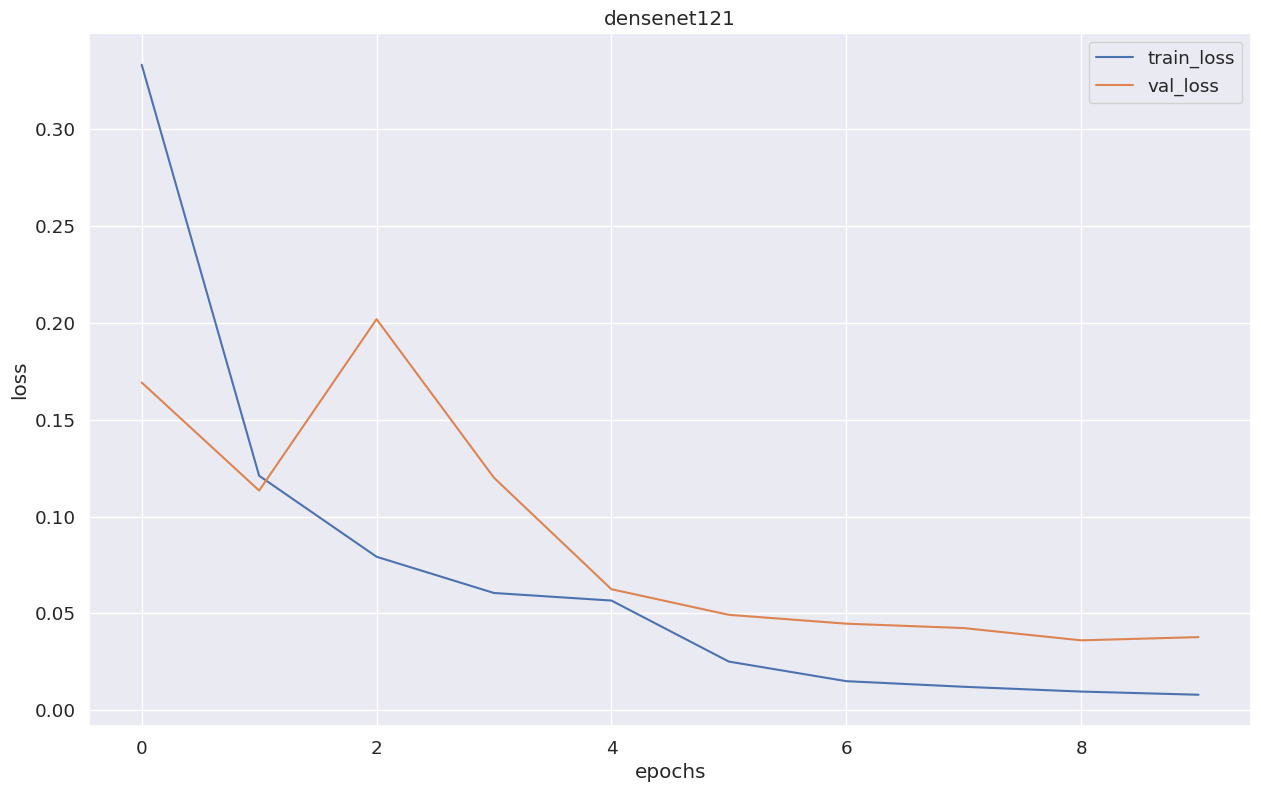

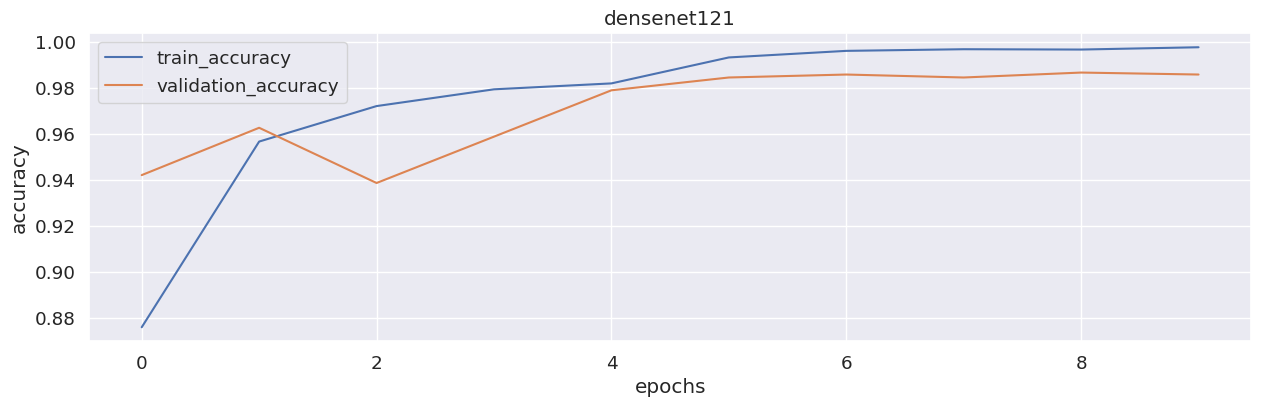

In [25]:
vizualize(history_2, 'densenet121')

## Test

In [26]:
result_1 = predict(resnet, test_dataloader)
result_2 = predict(mobilenet, test_dataloader)
result_3 = predict(dnet, test_dataloader)

In [27]:
print(f'Test Accuracy for resnet50 -- {result_1[3]:.2}')
print(f'Test Accuracy for mobilenetV2 -- {result_2[3]:.2}')
print(f'Test Accuracy for densenet121 -- {result_3[3]:.2}')

Test Accuracy for resnet50 -- 0.99
Test Accuracy for mobilenetV2 -- 0.99
Test Accuracy for densenet121 -- 0.99


In [28]:
result = result_1

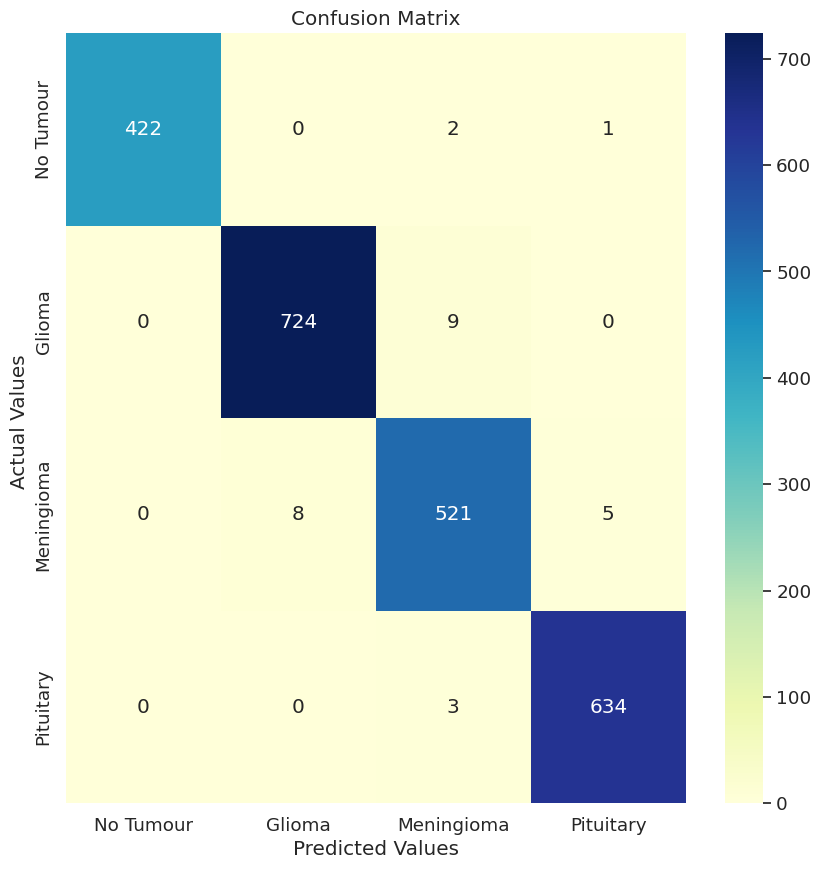

In [29]:
conf_mx = pd.DataFrame(confusion_matrix(result[1], result[0]))

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mx, annot= True , fmt="d",  cmap='YlGnBu', ax=ax)

ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['No Tumour','Glioma', 'Meningioma', 'Pituitary'])
ax.yaxis.set_ticklabels(['No Tumour','Glioma', 'Meningioma', 'Pituitary'])
plt.show()

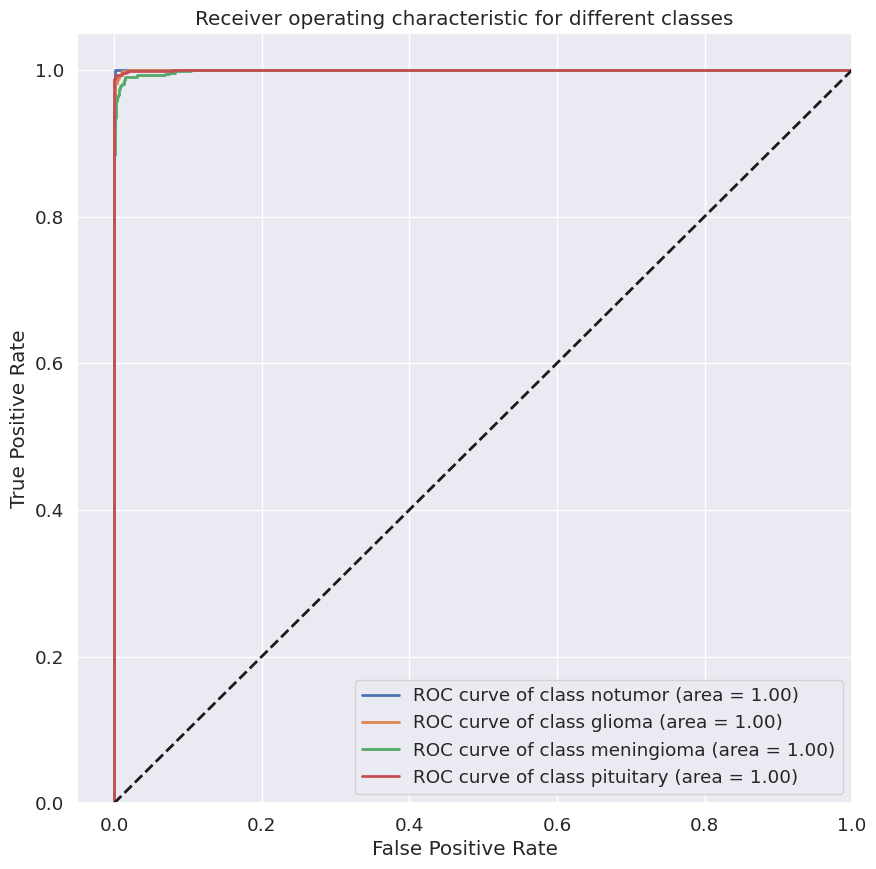

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
fpr = dict()
tpr = dict()
roc_auc = dict()
classes = list(CLASSES.values())
labels = list(CLASSES.keys())
label_test = label_binarize(result[0], classes=classes)
n_classes = label_test.shape[1]
y_score = result[2]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(label_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for different classes')
plt.legend(loc="lower right")
plt.show()

## Results

- The best metric?? Let it be the ResNet50

## Save the best model weights

In [31]:
!mkdir /kaggle/working/result

In [32]:
torch.save(resnet.state_dict(), outDir + 'resnet50.pth')

# Part II: Detection

## Load annotations

In [33]:
coco = COCO(anns)
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
COCO categories: 
tumour



## Dataset

**Previously about 1100 images were marked with CVAT. To upsample the dataset all the images and bboxes are flipped.**

In [34]:
class Tumour(torch.utils.data.Dataset):
    def __init__(self, root, coco, size, hf=False, vf=False):
        self.root = root
        self.hf = hf
        self.vf = vf
        self.coco = coco
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.size = size

    def __getitem__(self, index):
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = self.coco.loadAnns(ann_ids)

        # open the input image
        path = self.coco.loadImgs(img_id)[0]["file_name"]
        img = Image.open(os.path.join(self.root, path))
        kx = self.size / img.size[0]
        ky = self.size / img.size[1]
        kh = 0
        kv = 0
        transformer = [transforms.ToTensor(),
                       transforms.Resize((self.size, self.size)),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]

        if self.hf:
            kh = 1
            transformer.append(transforms.RandomHorizontalFlip(1))
        if self.vf:
            kv = 1
            transformer.append(transforms.RandomVerticalFlip(1))


        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height] (Upper-Left)
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            width = coco_annotation[i]['bbox'][2]
            height = coco_annotation[i]['bbox'][3]

            x1 = abs(self.size * kh - xmin * kx)
            y1 = abs(self.size * kv - ymin * ky)
            w = width * kx
            h = height * ky

            if self.hf == True and self.vf == True:
                boxes.append([x1 - w, y1 - h, x1, y1])
            elif self.hf == True and self.vf == False:
                boxes.append([x1 - w, y1, x1, y1 + h])
            elif self.hf == False and self.vf == True:
                boxes.append([x1, y1 - h, x1 + w, y1])
            else:
                boxes.append([x1, y1, x1 + w, y1 + h])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor([ann["category_id"] for ann in coco_annotation], dtype=torch.int64)

        # Annotation is in dictionary format
        new_annotation = {}
        new_annotation["boxes"] = boxes
        new_annotation["labels"] = labels

        tr = transforms.Compose(transformer)
        img = tr(img)

        return img, new_annotation

    def __len__(self):
        return len(self.ids)

In [35]:
imgs_00 = Tumour(root=detDir, coco=coco, size=IMG_SIZE_D, hf=False, vf=False)
imgs_h0 = Tumour(root=detDir, coco=coco, size=IMG_SIZE_D, hf=True, vf=False)
imgs_v0 = Tumour(root=detDir, coco=coco, size=IMG_SIZE_D, hf=False, vf=True)
imgs_hv = Tumour(root=detDir, coco=coco, size=IMG_SIZE_D, hf=True, vf=True)
imgs = torch.utils.data.ConcatDataset([imgs_00, imgs_h0, imgs_v0, imgs_hv])

In [36]:
train_d, valid_d, test_d = torch.utils.data.random_split(imgs, [.6, .2, .2], generator=generator)
print(f"train - {len(train_d)} \n valid - {len(valid_d)} \n test - {len(test_d)}")

train - 2640 
 valid - 880 
 test - 880


## Dataloaders

In [37]:
dataset_list = {'train': train_d, 'val': valid_d}
dataloaders = {x: torch.utils.data.DataLoader(dataset_list[x], batch_size=4,
                                             shuffle=True, num_workers=0, collate_fn=lambda batch: tuple(zip(*batch))) for x in ['train', 'val']}

## First look

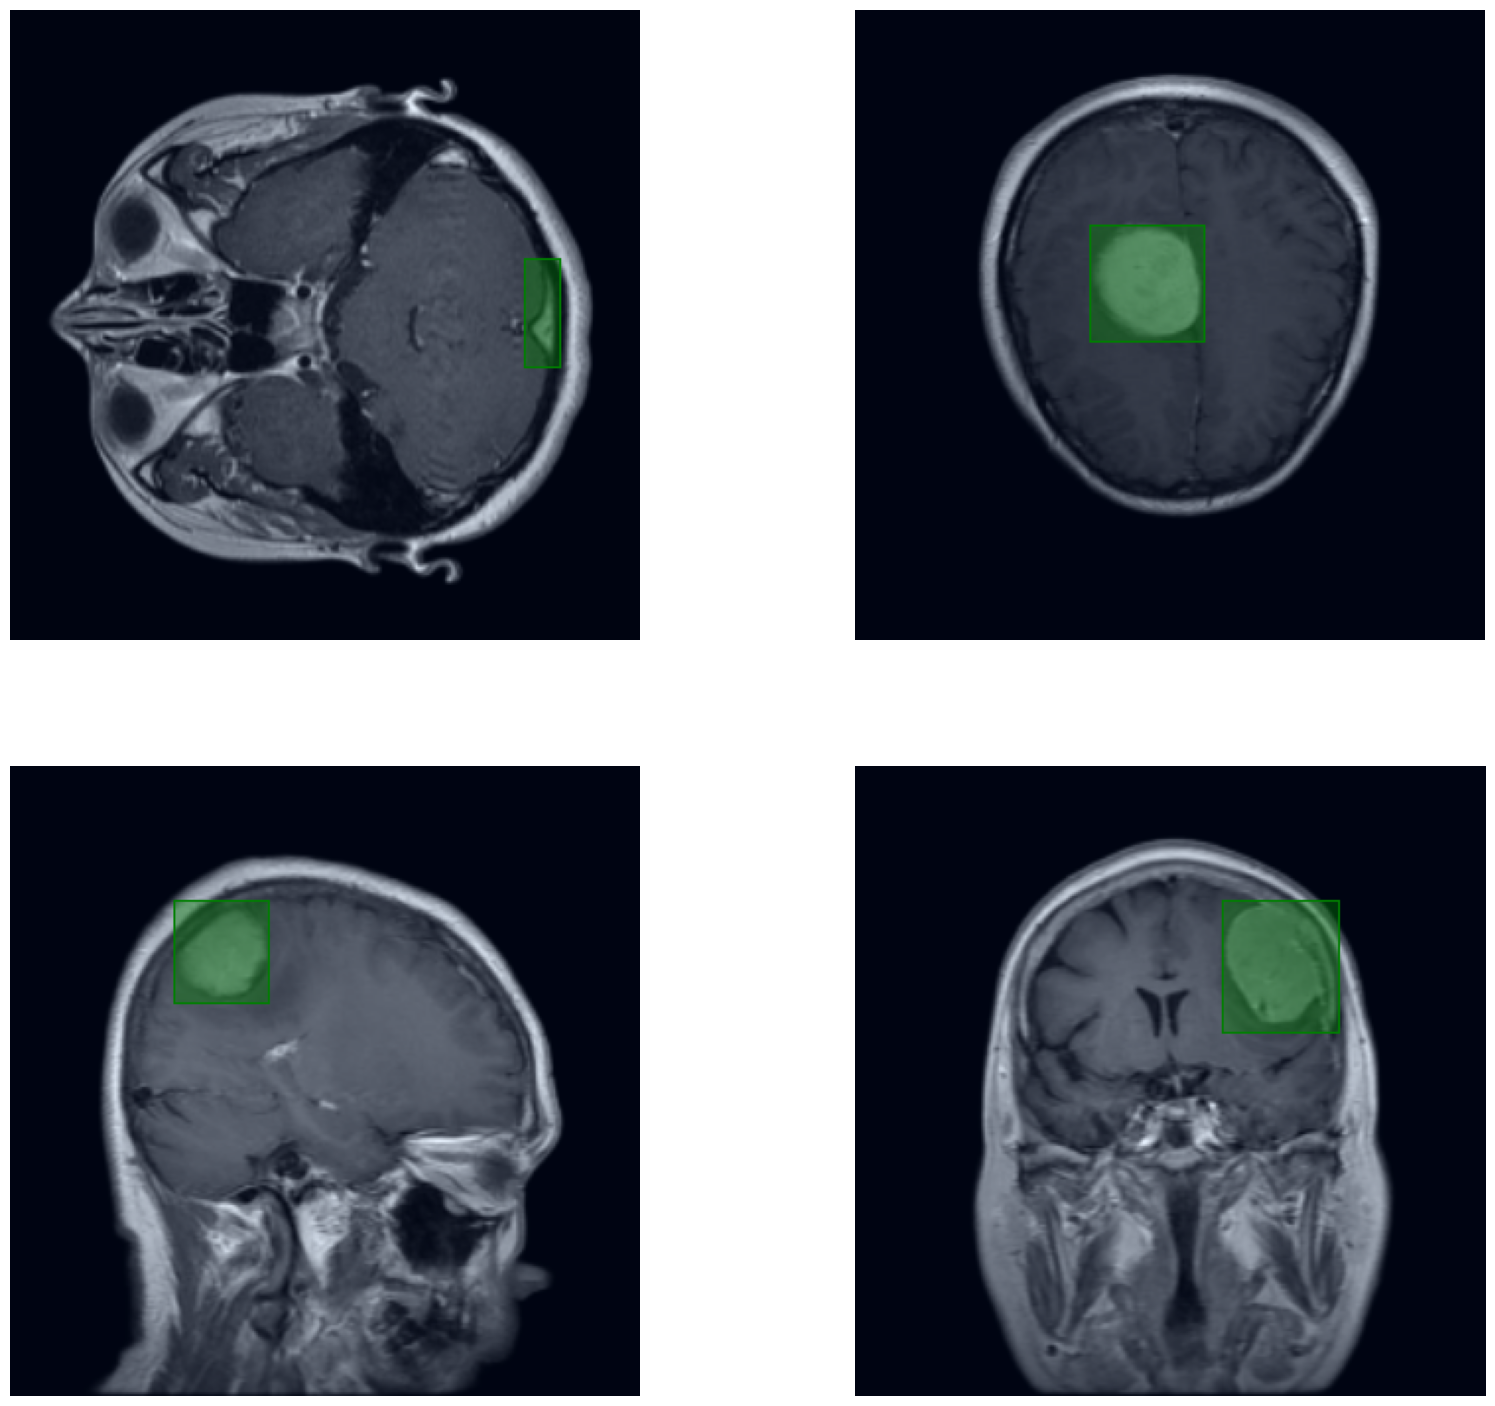

In [38]:
idx = np.random.randint(0, len(imgs), 4)
fig = plt.figure(figsize=(20,18))
for i in range(len(idx)):
    fig.add_subplot(2, 2, i+1)
    data = imgs[idx[i]]
    look = data[0]
    look = (255.0 * (look - look.min()) / (look.max() - look.min())).to(torch.uint8)
    boxes = data[1]['boxes']
    look = draw_bounding_boxes(look, boxes, fill=True, colors=['green']*len(boxes), width=1)
    plt.imshow(look.permute(1, 2, 0))
    plt.axis("off")
plt.show()

## Loading model

In [39]:
ssd = models.detection.ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT, weights_backbone=models.VGG16_Weights, pretrained=True, score_thresh = .25)

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 246MB/s]


In [40]:
def create_model(model, num_classes=91, size=IMG_SIZE_D):
    in_channels = _utils.retrieve_out_channels(model.backbone, (size, size))
    num_anchors = model.anchor_generator.num_anchors_per_location()
    model.head.classification_head = SSDClassificationHead(
       in_channels=in_channels,
       num_anchors=num_anchors,
       num_classes=num_classes,
   )
    # Image size for transforms.
    model.transform.min_size = (size,)
    model.transform.max_size = size
    return model

ssd_model = create_model(ssd, 2, IMG_SIZE_D)

## Classes and functions for training

In [41]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save(model.state_dict(), outDir + 'ssd.pth')

In [42]:
def train(train_data_loader, model):
    model.train()
    print('Training')
    global train_itr
    global train_loss_list

     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [43]:
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    #global map_list

    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            model.train()
            loss_dict = model(images, targets)
            metric = MeanAveragePrecision(iou_type="bbox")
            model.eval()
            output = model(images, targets)
            metric.update(output, targets)
            map_50 = metric.compute()['map_50']

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        #map_list.append(map_50)
        #map_hist.send(map_50)
        val_loss_hist.send(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}---mAP50: {map_50:.4f}")
    return val_loss_list

## Training

In [44]:
model = ssd_model.to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)
train_loss_hist = Averager()
val_loss_hist = Averager()
#map_hist = Averager()
train_itr = 1
val_itr = 1
# train and validation loss lists to store loss values of all...
# ... iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []
#map_list = []
save_best_model = SaveBestModel()
# name to save the trained model with

# start the training epochs
NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()
    # start timer and carry out training and validation
    start = time()
    train_loss = train(dataloaders['train'], model)
    # exp_lr_scheduler.step()
    val_loss = validate(dataloaders['val'], model)
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")
    end = time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")
    # save the best model till now if we have the least loss in the...
    # ... current epoch
    save_best_model(
            val_loss_hist.value, epoch, model, optimizer
        )


EPOCH 1 of 10
Training


Loss: 2.0822: 100%|██████████| 660/660 [01:40<00:00,  6.58it/s]


Validating


Loss: 3.1367---mAP50: 0.9505: 100%|██████████| 220/220 [00:35<00:00,  6.21it/s]


Epoch #1 train loss: 3.206
Epoch #1 validation loss: 2.696
Took 2.263 minutes for epoch 1

Best validation loss: 2.695809841697866

Saving best model for epoch: 1


EPOCH 2 of 10
Training


Loss: 1.3235: 100%|██████████| 660/660 [01:39<00:00,  6.66it/s]


Validating


Loss: 2.1224---mAP50: 1.0000: 100%|██████████| 220/220 [00:35<00:00,  6.26it/s]


Epoch #2 train loss: 2.380
Epoch #2 validation loss: 2.364
Took 2.237 minutes for epoch 2

Best validation loss: 2.3644583168354902

Saving best model for epoch: 2


EPOCH 3 of 10
Training


Loss: 2.5859: 100%|██████████| 660/660 [01:39<00:00,  6.66it/s]


Validating


Loss: 1.9506---mAP50: 0.7921: 100%|██████████| 220/220 [00:35<00:00,  6.25it/s]


Epoch #3 train loss: 2.069
Epoch #3 validation loss: 2.385
Took 2.238 minutes for epoch 3

EPOCH 4 of 10
Training


Loss: 1.0374: 100%|██████████| 660/660 [01:38<00:00,  6.67it/s]


Validating


Loss: 1.7193---mAP50: 1.0000: 100%|██████████| 220/220 [00:35<00:00,  6.26it/s]


Epoch #4 train loss: 1.791
Epoch #4 validation loss: 2.295
Took 2.235 minutes for epoch 4

Best validation loss: 2.294988191127777

Saving best model for epoch: 4


EPOCH 5 of 10
Training


Loss: 2.1879: 100%|██████████| 660/660 [01:38<00:00,  6.67it/s]


Validating


Loss: 2.5214---mAP50: 0.7525: 100%|██████████| 220/220 [00:35<00:00,  6.19it/s]


Epoch #5 train loss: 1.600
Epoch #5 validation loss: 2.282
Took 2.240 minutes for epoch 5

Best validation loss: 2.28167082992467

Saving best model for epoch: 5


EPOCH 6 of 10
Training


Loss: 1.4593: 100%|██████████| 660/660 [01:38<00:00,  6.67it/s]


Validating


Loss: 2.0044---mAP50: 0.7525: 100%|██████████| 220/220 [00:35<00:00,  6.24it/s]


Epoch #6 train loss: 1.347
Epoch #6 validation loss: 2.494
Took 2.238 minutes for epoch 6

EPOCH 7 of 10
Training


Loss: 0.6895: 100%|██████████| 660/660 [01:38<00:00,  6.67it/s]


Validating


Loss: 4.3887---mAP50: 0.5050: 100%|██████████| 220/220 [00:35<00:00,  6.26it/s]


Epoch #7 train loss: 1.179
Epoch #7 validation loss: 2.729
Took 2.234 minutes for epoch 7

EPOCH 8 of 10
Training


Loss: 2.5730: 100%|██████████| 660/660 [01:38<00:00,  6.68it/s]


Validating


Loss: 2.8703---mAP50: 0.7525: 100%|██████████| 220/220 [00:35<00:00,  6.24it/s]


Epoch #8 train loss: 1.044
Epoch #8 validation loss: 2.561
Took 2.235 minutes for epoch 8

EPOCH 9 of 10
Training


Loss: 1.0478: 100%|██████████| 660/660 [01:38<00:00,  6.68it/s]


Validating


Loss: 1.6570---mAP50: 1.0000: 100%|██████████| 220/220 [00:35<00:00,  6.26it/s]


Epoch #9 train loss: 0.857
Epoch #9 validation loss: 2.653
Took 2.232 minutes for epoch 9

EPOCH 10 of 10
Training


Loss: 0.4885: 100%|██████████| 660/660 [01:38<00:00,  6.69it/s]


Validating


Loss: 3.9920---mAP50: 0.5050: 100%|██████████| 220/220 [00:35<00:00,  6.25it/s]

Epoch #10 train loss: 0.780
Epoch #10 validation loss: 2.825
Took 2.232 minutes for epoch 10


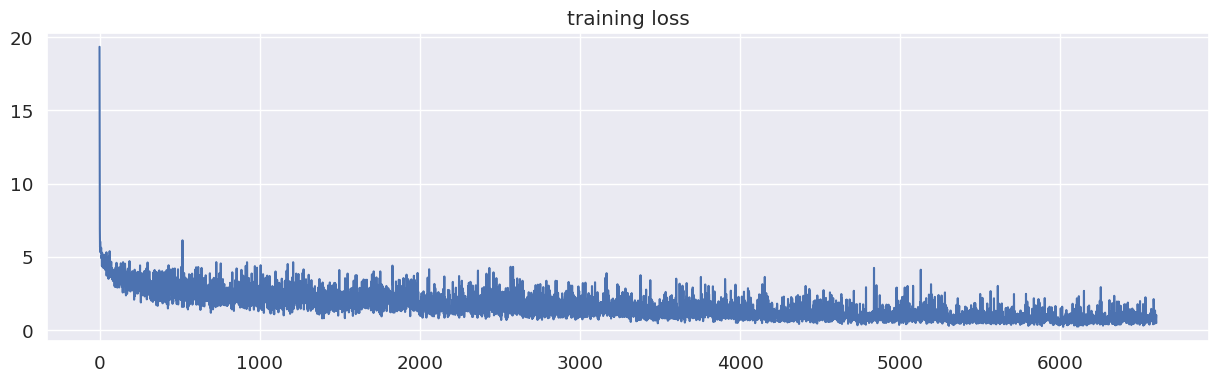

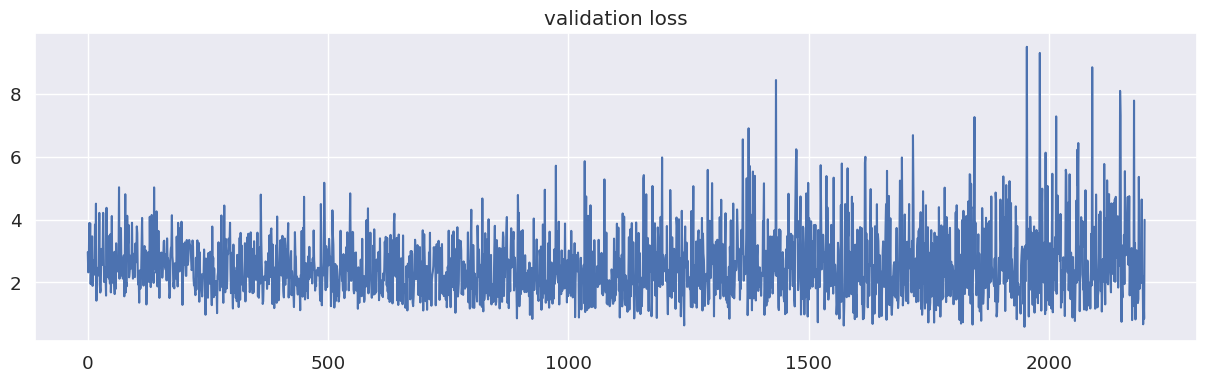

In [45]:
plt.plot(train_loss)
plt.title('training loss')
plt.show()
plt.plot(val_loss)
plt.title('validation loss')
plt.show()

## Function fos visualize images and bboxes

In [46]:
best_model_params_path = os.path.join(outDir, 'ssd.pth')
trained_model = model
trained_model.load_state_dict(torch.load(best_model_params_path))

<All keys matched successfully>

In [47]:
def draw(input, model):
    image = input[0]
    with torch.no_grad():
        x = image.to(device)
        predictions = model.eval()([x, ])
    pred = predictions[0]
    # print(pred)
    image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
    #pred_score = [f"value: {score:.3f}" for score in pred["scores"]]
    pred_label = [f"predicted tumour" for label in pred["labels"]]
    true_label = [f"true tumour" for label in input[1]["labels"]]
    pred_boxes = pred["boxes"].long()
    true_boxes = input[1]['boxes'].long()
    output_image = draw_bounding_boxes(image, pred_boxes, pred_label, fill=True, colors=['blue']*len(pred_label), width=1)
    output_image = draw_bounding_boxes(output_image, true_boxes, true_label, fill=False, colors=['red']*len(true_label), width=1)
    targets = [{k: v.to(device) for k, v in t.items()} for t in [input[1], ]]
    metric = MeanAveragePrecision(iou_type="bbox")
    metric.update(predictions, targets)
    map_50 = metric.compute()['map_50']
    metric_1 = IntersectionOverUnion()
    iou = metric_1(predictions, targets)


    return output_image, iou, map_50

## Try detection on test data

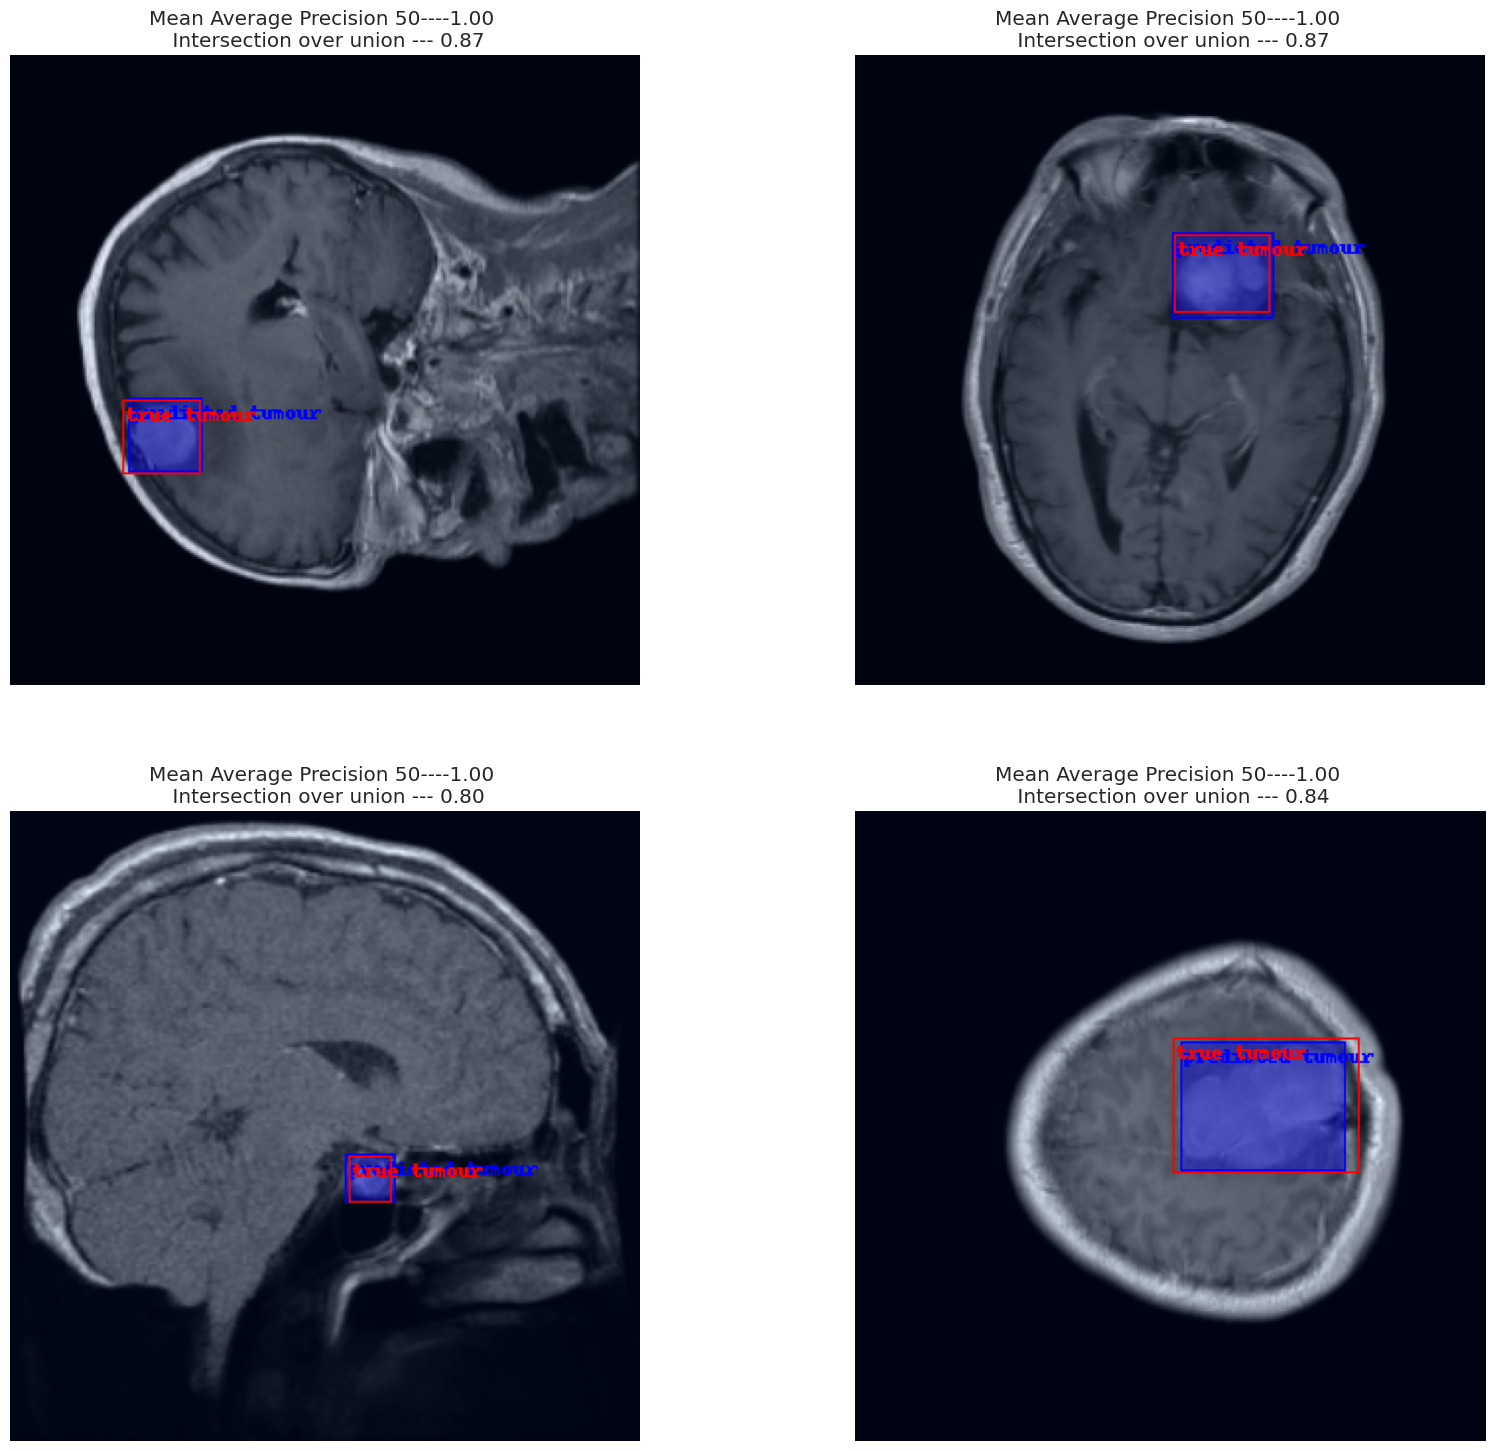

In [48]:
idx = np.random.randint(0, len(test_d), 4)
fig = plt.figure(figsize=(20,18))

for i in range(len(idx)):
    data = test_d[idx[i]]
    look, IoU, MaP = draw(data, trained_model)
    fig.add_subplot(2, 2, i+1).set_title((f'Mean Average Precision 50----{MaP:.2f} \n Intersection over union --- {IoU["iou"]:.2f}'))
    plt.imshow(look.permute(1, 2, 0))
    plt.axis("off")
plt.show()

## Results

In [49]:
result_iou = []
result_map50 = []
for data in test_d:
    _, iou, map_50 = draw(data, trained_model)
    if torch.isnan(iou['iou']):
        result_iou.append(torch.tensor(0).to(device))
    else:
        result_iou.append(iou['iou'])
    result_map50.append(map_50)

In [50]:
print(f'MAX mAP50 -- {float(max(result_map50)):.2}')
print(f'MAX IoU -- {float(max(result_iou)):.2}')
print(f'mean mAP50 -- {float(sum(result_map50) / len(result_map50)):.2}')
print(f'mean IoU -- {float(sum(result_iou) / len(result_iou)):.2}')

MAX mAP50 -- 1.0
MAX IoU -- 0.97
mean mAP50 -- 0.84
mean IoU -- 0.67
